In [7]:
# --- Step 1: Import Libraries and Load Data --- #
import pandas as pd

print("Libraries imported successfully.")

# Load the datasets
# Make sure the paths are correct for your project structure
try:
    df_train = pd.read_csv('../datasets/train.csv', low_memory=False, parse_dates=['Date']) # Parse dates during loading
    df_store = pd.read_csv('../datasets/store.csv', low_memory=False)
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'train.csv' and 'store.csv' are in your datasets folder.")
    exit()

Libraries imported successfully.
Files loaded successfully.


In [8]:
# --- Step 2: Merge the datasets into one --- #
df = pd.merge(df_train, df_store, how='left', on='Store')
print("Datasets merged successfully.")

Datasets merged successfully.


In [9]:
# --- Step 3: Filter for Open Stores Only (Lesson from EDA) --- #
# We only want to forecast sales for days the store was actually open.
df = df[df['Open'] == 1].copy()
print(f"Filtered down to {len(df)} records for open stores.")

Filtered down to 844392 records for open stores.


In [10]:
# --- Step 4: Select and Rename Columns for Prophet --- #
# Create the new DataFrame specifically for Prophet
# Prophet only needs the Date ('ds') and the value to forecast ('y')
df_prophet = df[['Date', 'Sales']].copy()

# Rename the columns to Prophet's required names
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})
print("Columns selected and renamed for Prophet.")

Columns selected and renamed for Prophet.


In [11]:
# --- Step 5: Verify the Final DataFrame --- #
# Check the first few rows and the data types
print("\n--- Data Prepared for Prophet (First 5 Rows) ---")
print(df_prophet.head())

print("\n--- Prophet Data Info ---")
df_prophet.info()

print("\n--- Final Data Shape ---")
print(df_prophet.shape)


--- Data Prepared for Prophet (First 5 Rows) ---
          ds      y
0 2015-07-31   5263
1 2015-07-31   6064
2 2015-07-31   8314
3 2015-07-31  13995
4 2015-07-31   4822

--- Prophet Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      844392 non-null  datetime64[ns]
 1   y       844392 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.3 MB

--- Final Data Shape ---
(844392, 2)


In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt
# --- Create and Train the Prophet Model ---#
# We initialize the model. Prophet automatically detects yearly and weekly seasonality.
print("Initializing and training Prophet model...")
model_prophet = Prophet(daily_seasonality=False) # Daily seasonality isn't strong in retail sales
model_prophet.fit(df_prophet)
print("Model training complete.")

Importing plotly failed. Interactive plots will not work.


Initializing and training Prophet model...


09:06:43 - cmdstanpy - INFO - Chain [1] start processing
09:11:18 - cmdstanpy - INFO - Chain [1] done processing


Model training complete.


In [13]:
# --- Create Future DataFrame --- #
# 'make_future_dataframe' creates a DataFrame with dates extending into the future.
print("Creating future dates for forecasting...")
future_dates = model_prophet.make_future_dataframe(periods=365) # Forecast 1 year ahead

# --- Make Predictions --- #
# The 'predict' method takes the future dates and calculates the forecast ('yhat')
print("Making predictions...")
forecast = model_prophet.predict(future_dates)
print("Predictions complete.")

# Display the last few rows of the forecast DataFrame
# Notice the 'yhat' (prediction), 'yhat_lower', and 'yhat_upper' (uncertainty interval) columns
print("\n--- Forecast Results (Last 5 Days) ---")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Creating future dates for forecasting...
Making predictions...
Predictions complete.

--- Forecast Results (Last 5 Days) ---
             ds         yhat    yhat_lower    yhat_upper
1302 2016-07-26  6925.213623  -8779.431713  20769.327243
1303 2016-07-27  6580.062225  -9162.324873  19849.151432
1304 2016-07-28  6640.184162  -9019.013050  20342.492147
1305 2016-07-29  6932.098911  -9093.366704  21114.117991
1306 2016-07-30  5719.142739 -10337.468416  19488.665602



Plotting the forecast...


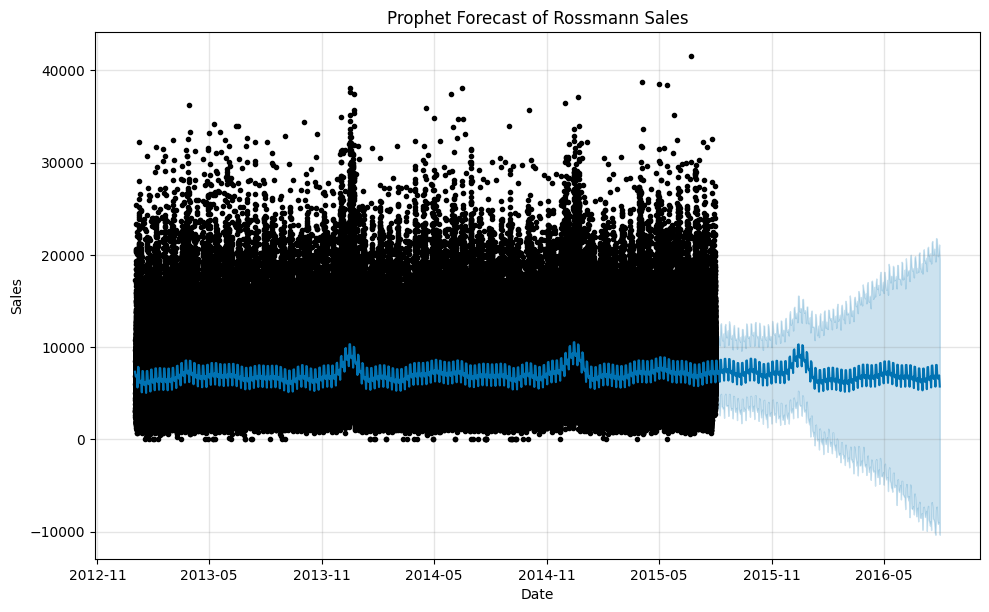


Plotting forecast components...


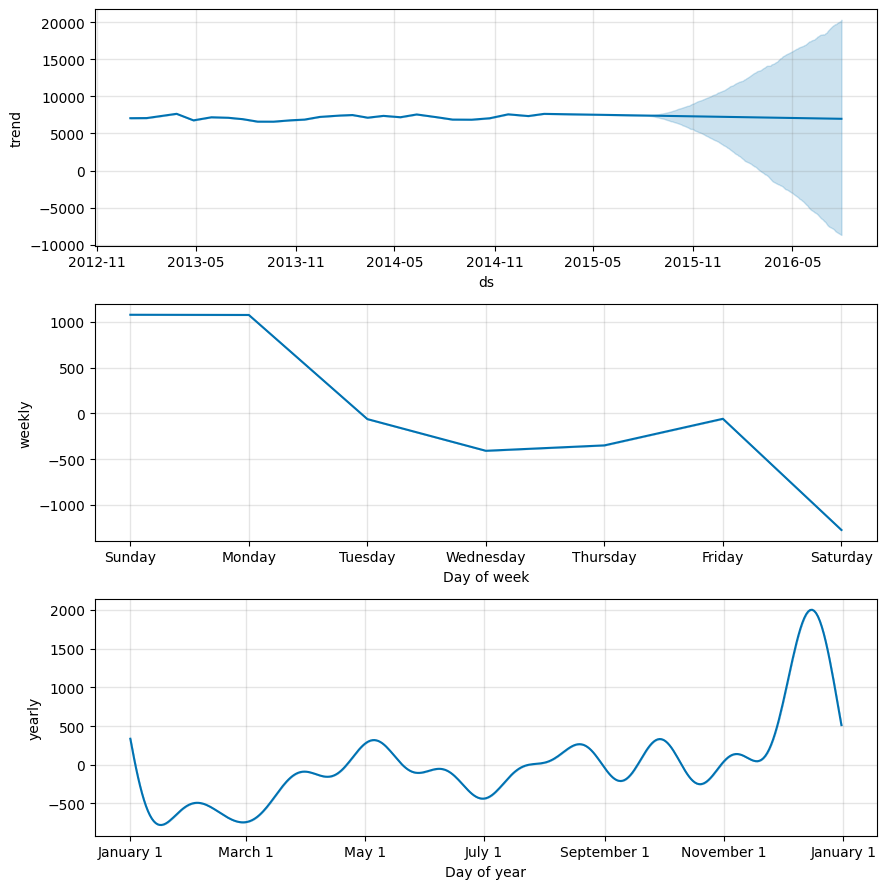

In [14]:
# --- Plot the Forecast --- #
print("\nPlotting the forecast...")
# Prophet's plot function shows historical data, the forecast, and the uncertainty interval.
fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast of Rossmann Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# --- Plot Forecast Components --- #
# This plot breaks down the forecast into its trend, yearly seasonality, and weekly seasonality.
# It helps us understand *why* the model is making its predictions.
print("\nPlotting forecast components...")
fig2 = model_prophet.plot_components(forecast)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error

# --- Evaluate Prophet's Performance --- #

# 1. Merge the forecast with the original data
#    This aligns the predictions ('yhat') with the actual sales ('y')
#    We use an inner merge to only keep dates present in both.
df_performance = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')

# 2. Calculate the Mean Absolute Error (MAE)
#    This compares the actual sales ('y') to Prophet's predictions ('yhat').
prophet_mae = mean_absolute_error(df_performance['y'], df_performance['yhat'])

# 3. Print the result
print(f"Prophet Model MAE: €{prophet_mae:,.2f}")

# Optional: You can also print the MAE from your previous Random Forest model for comparison
# (Replace 789.71 with your actual Random Forest MAE)
rf_mae = 789.71
print(f"Random Forest MAE: €{rf_mae:,.2f}")

# Compare the two
if prophet_mae < rf_mae:
    print("\nProphet model is more accurate than the Random Forest!")
else:
    print("\nRandom Forest model is more accurate than Prophet.")

Prophet Model MAE: €2,193.47
Random Forest MAE: €789.71

Random Forest model is more accurate than Prophet.
